<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Real-data---20-news-groups" data-toc-modified-id="Real-data---20-news-groups-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Real data - 20 news groups</a></span></li><li><span><a href="#Time-Forest" data-toc-modified-id="Time-Forest-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Time Forest</a></span></li><li><span><a href="#Average-result-for-every-target" data-toc-modified-id="Average-result-for-every-target-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Average result for every target</a></span><ul class="toc-item"><li><span><a href="#Optimize-hyper-params" data-toc-modified-id="Optimize-hyper-params-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Optimize hyper-params</a></span></li><li><span><a href="#Plot-benchmark-Vs-challenger:" data-toc-modified-id="Plot-benchmark-Vs-challenger:-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Plot benchmark Vs challenger:</a></span></li><li><span><a href="#Optimized-vs-challenger" data-toc-modified-id="Optimized-vs-challenger-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Optimized vs challenger</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pdb
import warnings
import seaborn as sns
import os
import glob
import sys

from sklearn import metrics
from time import time
from time_robust_forest.models import TimeForestClassifier
from time_robust_forest.functions import check_categoricals_match, check_numerical_match
from time_robust_forest.hyper_opt import env_wise_hyper_opt
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm_notebook
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')

In [2]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
set_style()

In [4]:
np.random.seed(42)

## Real data - 20 news groups

In [5]:
MAX_VOCABULARY = 100
TARGET = 1
PREFIX = "20news"

In [6]:
train = fetch_20newsgroups(subset="train") 
test = fetch_20newsgroups(subset="test")

del test["DESCR"]
del train["DESCR"]

in_time = pd.DataFrame.from_dict(train, orient="index").transpose() 

out_of_time = pd.DataFrame.from_dict(test, orient="index").transpose()

In [7]:
in_time.shape

(11314, 4)

In [8]:
in_time["target"].value_counts()

10    600
15    599
8     598
9     597
11    595
13    594
7     594
14    593
5     593
12    591
2     591
3     590
6     585
1     584
4     578
17    564
16    546
0     480
18    465
19    377
Name: target, dtype: int64

In [9]:
out_of_time["target"].value_counts()

10    399
8     398
15    398
9     397
13    396
7     396
11    396
5     395
2     394
14    394
12    393
3     392
6     390
1     389
4     385
17    376
16    364
0     319
18    310
19    251
Name: target, dtype: int64

In [10]:
in_time.tail()

,data,filenames,target_names,target
11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...,/Users/luis.moneda/scikit_learn_data/20news_ho...,None,13
11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...,/Users/luis.moneda/scikit_learn_data/20news_ho...,None,4
11311,From: westes@netcom.com (Will Estes)\nSubject:...,/Users/luis.moneda/scikit_learn_data/20news_ho...,None,3
11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...,/Users/luis.moneda/scikit_learn_data/20news_ho...,None,1
11313,From: gunning@cco.caltech.edu (Kevin J. Gunnin...,/Users/luis.moneda/scikit_learn_data/20news_ho...,None,8


In [11]:
out_of_time.shape

(7532, 4)

In [12]:
in_time[pd.isnull(in_time["data"])]

,data,filenames,target_names,target


In [13]:
out_of_time[pd.isnull(out_of_time["data"])]

,data,filenames,target_names,target


In [14]:
def preprocess(data):
    data["data"] = data["data"].apply(lambda x: " ".join(x.split("Lines: ")[1:]))
    
    return data

In [15]:
out_of_time = preprocess(out_of_time)
in_time = preprocess(in_time)

In [16]:
out_of_time["binary_target"] = out_of_time["target"].apply(lambda x: 1 if x == TARGET else 0)
in_time["binary_target"] = in_time["target"].apply(lambda x: 1 if x == TARGET else 0)

In [17]:
time_step = 2840
time_column = "date"
dummy_time_column = "dummy_date"
target = "binary_target"

In [18]:
in_time[time_column] = (in_time.index.values / time_step).astype(int)

<AxesSubplot:>

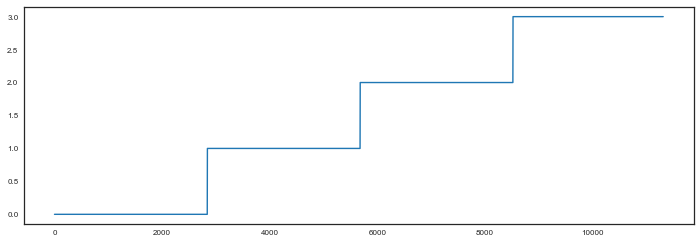

In [19]:
in_time[time_column].plot()

In [20]:
in_time.groupby(time_column).count()

,data,filenames,target_names,target,binary_target
date,,,,,
0,2840,2840,20,2840,2840
1,2840,2840,0,2840,2840
2,2840,2840,0,2840,2840
3,2794,2794,0,2794,2794


<AxesSubplot:>

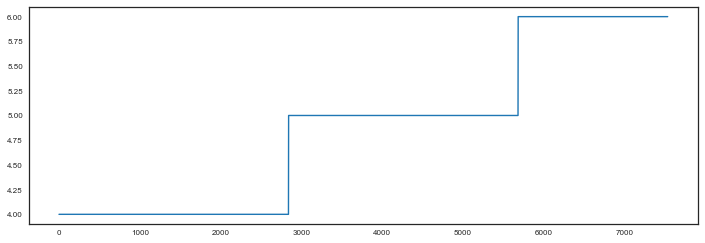

In [21]:
out_of_time[time_column] = ((out_of_time.index.values) / time_step).astype(int) + np.max(in_time.date.values) + 1
out_of_time[time_column].plot()

In [22]:
out_of_time.groupby(time_column).count()

,data,filenames,target_names,target,binary_target
date,,,,,
4,2840,2840,20,2840,2840
5,2840,2840,0,2840,2840
6,1852,1852,0,1852,1852


In [23]:
train, test = train_test_split(in_time, 
                               test_size=0.2, 
                               random_state=42)

In [24]:
vectorizer = TfidfVectorizer(max_features=MAX_VOCABULARY,
                             stop_words="english",
                             binary=False,
                             use_idf=True,
                             norm=False)

train_vectors = pd.DataFrame(vectorizer.fit_transform(train["data"]).toarray(), columns=vectorizer.vocabulary_)
test_vectors = pd.DataFrame(vectorizer.transform(test["data"]).toarray(), columns=vectorizer.vocabulary_)
oot_vectors = pd.DataFrame(vectorizer.transform(out_of_time["data"]).toarray(), columns=vectorizer.vocabulary_)

In [25]:
features = list(vectorizer.vocabulary_.keys())

In [26]:
train.iloc[0]["data"]

"5\n\nNikon FM-2n with 50 mm Nikkor and accessories for sale.I bought this camera in\nHong Kong two years ago and everything has been looked after very well. I'm now\nselling some more gear to finance my next big film project.\n\nAsking $350 for package. NO BARGAINS.\n"

In [27]:
train.head()

,data,filenames,target_names,target,binary_target,date
6606,5\n\nNikon FM-2n with 50 mm Nikkor and accesso...,/Users/luis.moneda/scikit_learn_data/20news_ho...,None,6,0,2
10808,"125\n\nHeres the life of St. MAria Goretti, po...",/Users/luis.moneda/scikit_learn_data/20news_ho...,None,15,0,3
10683,90\n\nkwfinken@pooh.harpo.uccs.edu (Kevin W. F...,/Users/luis.moneda/scikit_learn_data/20news_ho...,None,15,0,3
2089,18\nNntp-Posting-Host: cat.lv-lib.nevada.edu\n...,/Users/luis.moneda/scikit_learn_data/20news_ho...,None,2,0,0
4026,"15\n\nIn article <114152@bu.edu>, lcai@acs2.bu...",/Users/luis.moneda/scikit_learn_data/20news_ho...,None,3,0,1


In [28]:
train_vectors[time_column] = train[time_column].values
test_vectors[time_column] = test[time_column].values
oot_vectors[time_column] = out_of_time[time_column].values

In [29]:
train_vectors[dummy_time_column] = 1

In [30]:
train_vectors

,years,like,set,little,time,day,jesus,god,did,work,...,right,software,state,better,university,things,ax,g9v,date,dummy_date
0,0.0,0.000000,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.211018,2,1
1,0.0,0.000000,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,2.995159,0.000000,0.000000,0.000000,9.633054,3,1
2,0.0,0.000000,0.0,0.00000,0.000000,0.00000,3.434918,0.000000,0.000000,0.0,...,0.000000,2.711955,0.000000,2.995159,0.000000,0.000000,0.000000,6.422036,3,1
3,0.0,0.000000,0.0,3.50274,0.000000,3.37853,3.434918,0.000000,3.542663,0.0,...,0.000000,0.000000,7.471432,0.000000,0.000000,1.674975,0.000000,0.000000,0,1
4,0.0,0.000000,0.0,0.00000,0.000000,3.37853,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9046,0.0,3.182203,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,1
9047,0.0,3.182203,0.0,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,...,2.861526,0.000000,0.000000,0.000000,0.000000,6.699899,0.000000,0.000000,1,1
9048,0.0,0.000000,0.0,0.00000,3.535665,0.00000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.674975,0.000000,9.633054,1,1
9049,0.0,0.000000,0.0,0.00000,0.000000,0.00000,0.000000,3.663435,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.674975,0.000000,3.211018,0,1


In [31]:
model = TimeForestClassifier(time_column=dummy_time_column,
                             n_estimators=5,
                             multi=True, 
                             min_sample_periods=1)

model.fit(train_vectors[features + [dummy_time_column]], train[target].values)

In [32]:
train["prediction"] = model.predict_proba(train_vectors)[:, 1]
roc_auc_score(train[target], train["prediction"])

0.7556256805895851

In [33]:
test["prediction"] = model.predict_proba(test_vectors)[:, 1]
roc_auc_score(test[target], test["prediction"])

0.734269783019204

In [34]:
out_of_time["prediction"] = model.predict_proba(oot_vectors)[:, 1]

benchmark_dt_out_of_time = roc_auc_score(out_of_time[target], out_of_time["prediction"])
benchmark_dt_out_of_time

0.6882890362758297

In [35]:
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction"]))

date
4    0.710821
5    0.670313
6    0.678510
dtype: float64

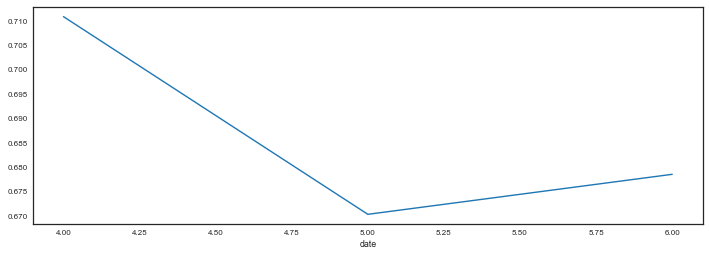

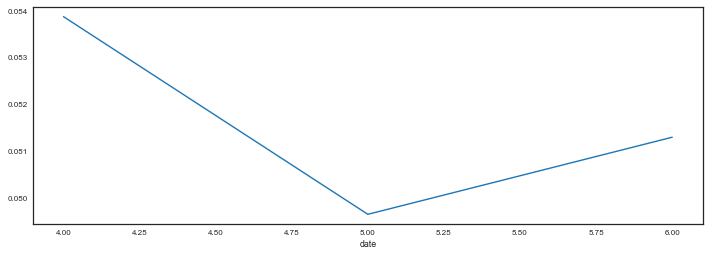

In [36]:
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction"])).plot()
plt.show()
out_of_time.groupby(time_column)[target].mean().plot()
plt.show()

In [37]:
model.feature_importance(impurity_decrease=True).head(10)

,Importance
Feature,
data,0.005073
20,0.002193
11,0.001969
host,0.001914
say,0.001603
didn,0.001316
file,0.001171
just,0.000993
question,0.000940


## Time Forest

In [38]:
time_model_tree = TimeForestClassifier(time_column=time_column,
                                       multi=True, 
                                       min_sample_periods=1)

# time_model_tree = RandomTimeSplitTree(train_vectors,
#                                 train[target].values,
#                                 time_column=time_column, 
#                                 max_depth=10,
#                                 max_features=1.0,
#                                 bootstrapping=False,
#                                 min_sample_periods=15,
#                                 verbose=True)


time_model_tree.fit(train_vectors[features + [time_column]], train[target].values)

train["time_prediction_tree"] = time_model_tree.predict_proba(train_vectors)[:, 1]
print(roc_auc_score(train[target], train["time_prediction_tree"]))

test["time_prediction_tree"] = time_model_tree.predict_proba(test_vectors)[:, 1]
print(roc_auc_score(test[target], test["time_prediction_tree"]))

out_of_time["time_prediction_tree"] = time_model_tree.predict_proba(oot_vectors)[:, 1]
print(roc_auc_score(out_of_time[target], out_of_time["time_prediction_tree"]))

0.7425013611791701
0.7255896604553389
0.7100972890567897


In [39]:
time_model_tree.feature_importance(impurity_decrease=True).head(10)

,Importance
Feature,
data,0.005360
11,0.002290
20,0.002048
host,0.002004
say,0.001773
just,0.001667
file,0.001212
best,0.001204
like,0.000967


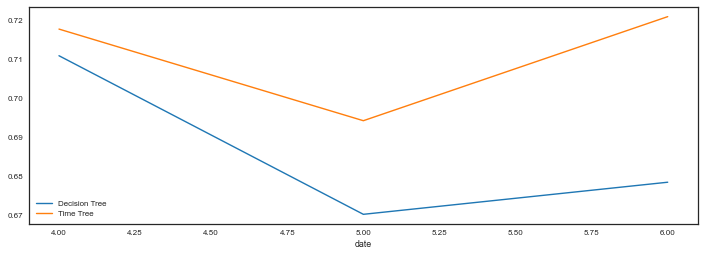

In [40]:
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction"])).plot(label="Decision Tree")
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["time_prediction_tree"])).plot(label="Time Tree")
plt.legend()
plt.show()

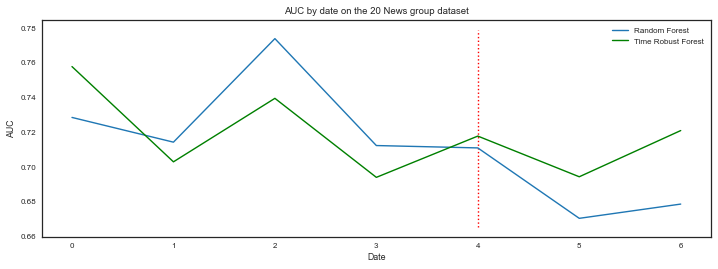

In [41]:
out_of_time_min_date = out_of_time["date"].min()
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction"])).plot(label="Random Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["time_prediction_tree"])).plot(label="Time Robust Forest", color="green")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(out_of_time_min_date, ymin, ymax, linestyle="dotted", color="red")
plt.legend()
plt.title("AUC by date on the 20 News group dataset")
plt.ylabel("AUC")
plt.xlabel("Date")
plt.show()

## Average result for every target

In [42]:
label_dict = in_time.groupby("target_names")["target"].min()
label_dict = {v: k for k, v in label_dict.items()}
label_dict

{7: 'talk.politics.mideast',
 4: 'sci.electronics',
 1: 'talk.politics.guns',
 14: 'sci.med',
 16: 'comp.windows.x',
 13: 'misc.forsale',
 3: 'rec.autos',
 2: 'rec.motorcycles',
 8: 'rec.sport.hockey',
 19: 'sci.crypt',
 6: 'sci.space',
 0: 'soc.religion.christian',
 12: 'talk.politics.misc',
 5: 'talk.religion.misc'}

In [43]:
from pycaret.classification import *

In [98]:
# params_grid = {"n_estimators": [30], 
#               "max_depth": [5, 10, 15],
#               "min_impurity_decrease": [1e-3, 0],
#               "min_sample_periods": [1, 5, 10],
#               "period_criterion": ["max", "avg"]}

params_grid = {"n_estimators": [4], 
              "max_depth": [5],
              "min_impurity_decrease": [0],
              "min_sample_periods": [1, 2],
              "period_criterion": ["max"]}

params_grid_benchmark = params_grid.copy()
params_grid_benchmark.pop("period_criterion")

['max']

### Optimize hyper-params 

In [99]:
benchmark_opt_param_dict = {}
challenger_opt_param_dict = {}

In [100]:
target

'binary_target'

In [101]:
in_time.groupby(time_column)[target].count()

date
0    2840
1    2840
2    2840
3    2794
Name: binary_target, dtype: int64

In [102]:
train = pd.DataFrame(vectorizer.fit_transform(in_time["data"]).toarray(), columns=vectorizer.vocabulary_)
holdout = pd.DataFrame(vectorizer.transform(out_of_time["data"]).toarray(), columns=vectorizer.vocabulary_)
features = list(vectorizer.vocabulary_.keys())

In [103]:
for i, target_label in enumerate(in_time["target"].unique()[:2]):
    print("*****************************")
    print("target_label = {}".format(label_dict[target_label]))
    holdout[target] = out_of_time["target"].apply(lambda x: 1 if x == target_label else 0)
    train[target] = in_time["target"].apply(lambda x: 1 if x == target_label else 0)
    train[time_column] = in_time[time_column]
    train[dummy_time_column] = 1
    
    challenger_boot = []
    benchmark_boot = []
    benchmark_boot_opt = []

    ### Challenger 
    model = TimeForestClassifier(time_column=time_column,
                                            multi=True)

    challenger_opt_param = env_wise_hyper_opt(train[features + [time_column]], train[target], 
                                             model, 
                                             time_column, 
                                             params_grid, 
                                             cv=5,
                                             score=roc_auc_score)
    
    challenger_opt_param_dict[label_dict[target_label]] = challenger_opt_param
    challenger_model = TimeForestClassifier(time_column=time_column,
                                           multi=True, 
                                           **challenger_opt_param)
    
    challenger_model.fit(train[features + [time_column]], train[target])
    
    train["challenger_prediction"] = challenger_model.predict_proba(train[features])[:, 1]
    holdout["challenger_prediction"] = challenger_model.predict_proba(holdout[features])[:, 1]
    


    print("Challenger params")
    print(challenger_opt_param)
    print("Challenger train perf")
    print(roc_auc_score(train[target], 
                        train["challenger_prediction"]))
    print("Challenger holdout perf")
    print(roc_auc_score(holdout[target], 
                        holdout["challenger_prediction"]))
    
    ### Benchmark
    model = TimeForestClassifier(time_column=dummy_time_column,
                                            multi=True)

    benchmark_opt_param = env_wise_hyper_opt(train[features + [dummy_time_column]], train[target], 
                                             model, 
                                             dummy_time_column, 
                                             params_grid_benchmark, 
                                             cv=5,
                                             score=roc_auc_score)
    
    benchmark_opt_param_dict[label_dict[target_label]] = benchmark_opt_param
    benchmark_model = TimeForestClassifier(time_column=dummy_time_column,
                                           multi=True, 
                                           **benchmark_opt_param)
    
    benchmark_model.fit(train[features + [dummy_time_column]], train[target])
    
    train["benchmark_prediction"] = benchmark_model.predict_proba(train[features])[:, 1]
    holdout["benchmark_prediction"] = benchmark_model.predict_proba(holdout[features])[:, 1]
    
    print("Benchmark params")
    print(benchmark_opt_param)
    print("Benchmark train perf")
    print(roc_auc_score(train[target], 
                        train["benchmark_prediction"]))
    print("Benchmark holdout perf")
    print(roc_auc_score(holdout[target], 
                        holdout["benchmark_prediction"]))

    

*****************************
target_label = talk.politics.mideast


KeyboardInterrupt: 

In [ ]:
N_BOOTS = 5
train_aucs = []
test_aucs = []
out_of_time_aucs = []

challenger_all_labels_auc = []
benchmark_all_labels_auc = []
benchmark_all_labels_auc_opt = []

challenger_train_auc = []
bechmark_train_auc = []
bechmark_opt_train_auc = []


for i, target_label in enumerate(in_time["target"].unique()[:2]):
    print("*****************************")
    print("target_label = {}".format(label_dict[target_label]))
    
    out_of_time["binary_target"] = out_of_time["target"].apply(lambda x: 1 if x == target_label else 0)
    in_time["binary_target"] = in_time["target"].apply(lambda x: 1 if x == target_label else 0)
    challenger_boot = []
    benchmark_boot = []
    benchmark_boot_opt = []    
    
    for n_boot in tqdm_notebook(range(N_BOOTS)):
        try:
            resampled_out_of_time = out_of_time.sample(frac=1.0, replace=True)
            train, test = train_test_split(in_time.sample(frac=1.0, replace=True), 
                                       test_size=0.2, 
                                       random_state=42)

            vectorizer = TfidfVectorizer(max_features=MAX_VOCABULARY,
                                 stop_words="english",
                                 binary=False,
                                 use_idf=True,
                                 norm=False)

            train_vectors = pd.DataFrame(vectorizer.fit_transform(train["data"]).toarray(), columns=vectorizer.vocabulary_)
            test_vectors = pd.DataFrame(vectorizer.transform(test["data"]).toarray(), columns=vectorizer.vocabulary_)
            oot_vectors = pd.DataFrame(vectorizer.transform(resampled_out_of_time["data"]).toarray(), columns=vectorizer.vocabulary_)

            train_vectors[time_column] = train[time_column].values
            test_vectors[time_column] = test[time_column].values
            oot_vectors[time_column] = resampled_out_of_time[time_column].values
            
            train_vectors[dummy_time_column] = 1
            features = list(vectorizer.vocabulary_.keys())
            
            ### Time Forest
            challenger_model = TimeForestClassifier(time_column=time_column,
                                           multi=True, 
                                           **challenger_opt_param)
            challenger_model.fit(train_vectors[features + [time_column]], train[target])
            train["time_prediction_tree"] = challenger_model.predict_proba(train_vectors[features])[:, 1]
            train_auc = roc_auc_score(train[target], train["time_prediction_tree"])

            test["time_prediction_tree"] = challenger_model.predict_proba(test_vectors[features])[:, 1]
            test_auc = roc_auc_score(test[target], test["time_prediction_tree"])

            resampled_out_of_time["time_prediction_tree"] = challenger_model.predict_proba(oot_vectors[features])[:, 1]
            oot_auc = roc_auc_score(resampled_out_of_time[target], resampled_out_of_time["time_prediction_tree"])
            
            challenger_train_auc.append(train_auc)
            
            ### Benchmark
            model = TimeForestClassifier(time_column=dummy_time_column,
                                           multi=True, 
                                           **benchmark_opt_param_dict[label_dict[target_label]])
            
            model.fit(train_vectors[features + [dummy_time_column]], train[target])

            train["prediction"] = model.predict_proba(train_vectors[features])[:, 1]
            test["prediction"] = model.predict_proba(test_vectors[features])[:, 1]
            resampled_out_of_time["prediction"] = model.predict_proba(oot_vectors[features])[:, 1]

            benchmark_auc_by_date = pd.DataFrame(pd.concat([test, resampled_out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction"])), columns=["auc"]).reset_index()
            challenger_auc_by_date = pd.DataFrame(pd.concat([test, resampled_out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["time_prediction_tree"])), columns=["auc"]).reset_index()

            challenger_boot.append(challenger_auc_by_date)
            benchmark_boot.append(benchmark_auc_by_date) 
            
            train_auc = roc_auc_score(train[target], train["prediction"])
            bechmark_train_auc.append(train_auc)
        except:
            print("Failed label {}".format(target_label))
    
    challenger_auc_by_target = pd.concat(challenger_boot)
    benchmark_auc_by_target = pd.concat(benchmark_boot)    
    
    challenger_all_labels_auc.append(challenger_auc_by_target)
    benchmark_all_labels_auc.append(benchmark_auc_by_target)    
    
    sns.lineplot(data=benchmark_auc_by_target, x="date", y="auc", label="Random Forest")
    sns.lineplot(data=challenger_auc_by_target, x="date", y="auc", label="Time Robust Forest", color="green")
    xmin, xmax, ymin, ymax = plt.axis()
    plt.vlines(out_of_time_min_date, ymin, ymax, linestyle="dotted", color="red", label="Time split")

    plt.title("Test and Out of time AUC for label {}".format(label_dict.get(i, i)))
    plt.show()
    

In [ ]:
print(np.mean(bechmark_train_auc))
print(np.mean(challenger_train_auc))

### Plot benchmark Vs challenger:

In [ ]:
challenger_auc_by_target = pd.concat(challenger_all_labels_auc)
benchmark_auc_by_target = pd.concat(benchmark_all_labels_auc)  
    

sns.lineplot(data=benchmark_auc_by_target, x="date", y="auc", label="Decision Tree")
sns.lineplot(data=challenger_auc_by_target, x="date", y="auc", label="Time Tree", color="green")
xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(out_of_time_min_date, ymin, ymax, linestyle="dotted", color="red", label="Time split")

plt.title("Test and Out of time AUC for all labels")
plt.show()

In [ ]:
from matplotlib.collections import PolyCollection as p

In [ ]:
fig, ax = plt.subplots()
challenger_auc_by_target = pd.concat(challenger_all_labels_auc)
benchmark_auc_by_target = pd.concat(benchmark_all_labels_auc)  
    

sns.lineplot(data=benchmark_auc_by_target, x="date", y="auc", label="Decision Tree")
sns.lineplot(data=challenger_auc_by_target, x="date", y="auc", label="Time Robust Tree", color="green", linestyle="dashed")
xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(out_of_time_min_date, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")

#plt.title("Test and Out of time AUC for all labels")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Time period", fontsize=15)

__file__ = "../images/20news_same_capacity"
plt.savefig(__file__+".jpg", quality=95)
for c in ax.findobj(p):
    c.set_zorder(-1)
    c.set_rasterized(True)
ax.set_rasterization_zorder(0)

plt.savefig(__file__+".eps")
plt.savefig("../images/20news_aggregate.eps", format="eps", bbox_inches="tight")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
benchmark_auc_by_target = pd.concat(benchmark_all_labels_auc)  

sns.lineplot(data=benchmark_auc_by_target, x="date", y="auc", label="Decision Tree")
sns.lineplot(data=challenger_auc_by_target, x="date", y="auc", label="Time Robust Tree", color="green", linestyle="dashed")
xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(out_of_time_min_date, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")

#plt.title("Test and Out of time AUC for all labels")

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

plt.ylim([ymin, ymax])
plt.legend(fontsize=13, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=16)
plt.xlabel("Time period", fontsize=16)

__file__ = "../images/20news_pycaret_aggregate_opt_square"
plt.savefig(__file__+".jpg", quality=95)
for c in ax.findobj(p):
    c.set_zorder(-1)
    c.set_rasterized(True)
ax.set_rasterization_zorder(0)

plt.savefig(__file__+".eps")
plt.savefig("../images/20news_pycaret_aggregate_opt_square.eps", format="eps")
plt.show()

In [ ]:
# challenger_auc_by_target.to_csv("results/6_20newsgroups_example_challenger.csv")
# benchmark_auc_by_target.to_csv("results/6_20newsgroups_example_benchmark.csv")
# benchmark_auc_by_target_opt.to_csv("results/6_20newsgroups_example_benchmark_opt.csv")

Looking to the difference directly.

In [ ]:
challenger_auc_by_target["diff"] = challenger_auc_by_target["auc"] - benchmark_auc_by_target["auc"]

In [ ]:
challenger_auc_by_target

In [ ]:
sns.lineplot(data=challenger_auc_by_target, x="date", y="diff", label="Diff")
xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(out_of_time_min_date, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.hlines(0, xmin, xmax, linestyle="dotted", color="green", label="Challenger winning")
plt.legend()